In [1]:
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, precision_score, auc,
                             recall_score, average_precision_score)
from modules.viz import conf_mat
from modules.eval_funcs import amalgamate_preds

cv_folds = 5

In [2]:
def string_to_float_list(s, method='new'):
    if method == 'old':
        s = s.replace('[', '').replace('[', '').replace('\n', '')
        s = re.sub(r'\s+', ', ', re.sub(r'\s*\]', '', s))
#         print("STRING", s)
    return [float(val) for val in s.split(',')]

# Load Data:

In [3]:
def summary_stats(df):
    if 'actual' in df.columns:
        df.rename(columns={'actual': 'actuals'}, inplace=True)
        
    acc = accuracy_score(df.actuals, df.preds)
    f1 = f1_score(df.actuals, df.preds, average='macro')
    precision = precision_score(df.actuals, df.preds, average='macro', zero_division=0)
    recall = recall_score(df.actuals, df.preds, average='macro')
    
    # Create a prediction array from probs:
    pred_arr = np.array(df['proba'].tolist())
    roc_auc = roc_auc_score(df.actuals, pred_arr, average='macro', multi_class='ovr')
    
    # Calculate AUPR for each class
    aupr_scores = [average_precision_score(df.actuals == class_index, pred_arr[:, class_index]
                                          ) for class_index in range(pred_arr.shape[1])]
    mean_aupr = np.mean(aupr_scores)
    
    return {'acc': acc, 'f1': f1, 'precision': precision, 'recall': recall,
           'roc_auc': roc_auc, 'aupr': mean_aupr}

In [17]:
swin_img = 'models/swinv2/model_eval/'
tri_fusion = 'models/fusion/model_eval/'
ibp_mlp = 'models/IBP_MLP/model_eval'
fusion = 'output/Fusion/runs/best_fuse_run/'
enet = 'output/ENET/'

In [95]:
# Load Kinase Inhibitor metadata:
ki_meta = pd.read_csv('data/cwp_ki_moa.csv')
print(ki_meta.shape)
ki_meta.head(2)

(19765, 13)


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_PlateType,moa,target,smiles,clinical_phase,moa_src
0,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,source_1,UL001783,B03,Batch5_20221030,COMPOUND,AURK inhibitor,AURKA|AURKB|AURKC,Cc1csc(c1)-c1nnc(Nc2ccc(Oc3ncccc3-c3ccnc(N)n3)...,Phase 1,dr_hub
1,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,source_1,UL001783,B46,Batch5_20221030,COMPOUND,AURK inhibitor,AURKA|AURKB|AURKC,Cc1csc(c1)-c1nnc(Nc2ccc(Oc3ncccc3-c3ccnc(N)n3)...,Phase 1,dr_hub


## Return Prediction Dataframes:

In [23]:
def return_preds(pred_dir, method, cv_folds=5):
    cpnd_frames = []
    well_frames = []

    for i in range(cv_folds):
        cpnd_file = glob.glob(f'{pred_dir}/CV{i}_eval/cpnd*.csv')
        well_file = glob.glob(f'{pred_dir}/CV{i}_eval/well*.csv')
        cdf = pd.read_csv(cpnd_file[0])
        wdf = pd.read_csv(well_file[0])
        cpnd_frames.append(cdf)
        well_frames.append(wdf)

    # Create combined dataframes of predictions across folds:
    cpnd_comb = pd.concat(cpnd_frames, axis=0).reset_index(drop=True)
    well_comb = pd.concat(well_frames, axis=0).reset_index(drop=True)
    cpnd_comb['proba'] = cpnd_comb['proba'].apply(string_to_float_list, method=method)
    well_comb['proba'] = well_comb['proba'].apply(string_to_float_list, method=method)
    
    return cpnd_comb, well_comb

# Summary Statistics:

## Swin Image:

In [31]:
swin_cpnd, swin_well = return_preds(swin_img, method='new')

In [33]:
swin_cpnd_df = amalgamate_preds(swin_cpnd, 'cpnd_ids')
summary_stats(swin_cpnd_df)

{'acc': 0.6666666666666666,
 'f1': 0.6958562413939988,
 'precision': 0.7223717948717948,
 'recall': 0.6891504410622058,
 'roc_auc': 0.8903891744625895,
 'aupr': 0.6743125651910769}

In [34]:
summary_stats(swin_well)

{'acc': 0.5086614173228347,
 'f1': 0.5156309749533527,
 'precision': 0.5299316917556887,
 'recall': 0.5102600411926476,
 'roc_auc': 0.8293556964132762,
 'aupr': 0.5012733597895953}

## IBP MLP:

In [75]:
ibp_cpnd, ibp_well = return_preds(ibp_mlp, method='old')

In [76]:
summary_stats(ibp_cpnd)

{'acc': 0.6559139784946236,
 'f1': 0.6507266544197491,
 'precision': 0.6806501831501831,
 'recall': 0.6454739704739705,
 'roc_auc': 0.8944605757519939,
 'aupr': 0.6763566642321532}

In [77]:
summary_stats(ibp_well)

{'acc': 0.4861111111111111,
 'f1': 0.49803206495679947,
 'precision': 0.5046762372918698,
 'recall': 0.49432053944028914,
 'roc_auc': 0.8328365544673989,
 'aupr': 0.5138306028276413}

## Fusion:

In [99]:
fuse_cpnd, fuse_well = return_preds(fusion, method='old')

In [25]:
fuse_cpnd_df = amalgamate_preds(fuse_cpnd, 'cpnd_ids')
summary_stats(fuse_cpnd_df)

{'acc': 0.6979166666666666,
 'f1': 0.7056240981240982,
 'precision': 0.733980405559353,
 'recall': 0.6986832122126241,
 'roc_auc': 0.9073359725095406,
 'aupr': 0.741223030335291}

In [26]:
summary_stats(fuse_well)

{'acc': 0.573228346456693,
 'f1': 0.5661536124758205,
 'precision': 0.5833149743472675,
 'recall': 0.5622480545889381,
 'roc_auc': 0.8671299891316183,
 'aupr': 0.6076237281421811}

# Confusion Matrices:

In [32]:
conf_mat(cpnd_comb.actuals, cpnd_comb.preds, 'IBP MLP - Compounds', 
         f'{ibp_mlp}/cpnd_cm.png')

In [33]:
conf_mat(well_comb.actuals, well_comb.preds, 'IBP MLP - Wells', 
         f'{ibp_mlp}/well_cm.png')

# Replicate Inspection:

In [117]:
def match_id(row, ki_df, col_id):
    well_id_parts = row['well_ids'].split('~')
    data_src, data_batch, data_plate, well_id = well_id_parts[0], well_id_parts[1], well_id_parts[2], well_id_parts[3]

    # Search for matching row in ki_ibp
    match_row = ki_df[
        (ki_df['Metadata_Source'] == data_src) &
        (ki_df['Metadata_Batch'] == data_batch) &
        (ki_df['Metadata_Plate'] == data_plate) &
        (ki_df['Metadata_Well'] == well_id)
    ]

    if not match_row.empty:
        return match_row[col_id].values[0]
    else:
        return None

In [159]:
def replicate_agg(df, well_level=True):
    if 'actual' in df.columns:
        df.rename(columns={'actual': 'actuals'}, inplace=True)
    
    if well_level:
        # Aggregate by well:
        replicates = df.groupby(['well_ids']).agg({'cpnd_ids': 'first', 'preds': 'mean', 'actuals': 'mean'}).reset_index()
        replicates = replicates.groupby(['cpnd_ids']).size().reset_index(name='replicate_count')    
    else:
        replicates = df.groupby(['cpnd_ids']).size().reset_index(name='replicate_count')    
    replicate_counts = replicates['replicate_count'].value_counts().reset_index()
    replicate_counts.columns = ['replicates', 'count']

    # Calculate model accuracy for each number of replicates
    accuracy_for_replicates = []
    for replicate_count in replicate_counts['replicates']:
        subset = df[df['cpnd_ids'].isin(replicates[replicates['replicate_count'] == replicate_count]['cpnd_ids'])]
        # Amalgamate subset to compound level:
        ss_am = amalgamate_preds(subset, 'cpnd_ids')
        correct_predictions = (ss_am['preds'] == ss_am['actuals']).sum()
        total_predictions = len(ss_am)
        accuracy = correct_predictions / total_predictions
        accuracy_for_replicates.append((replicate_count, accuracy))

    # Create a DataFrame with replicate count and model accuracy
    accuracy_df = pd.DataFrame(accuracy_for_replicates, columns=['replicates', 'accuracy'])
    accuracy_df['n_data'] = replicate_counts['count']
    accuracy_df = accuracy_df.sort_values('replicates', ascending=False).reset_index(drop=True)
    
    return accuracy_df

In [160]:
def col_agg(df, col):
    if 'actual' in df.columns:
        df.rename(columns={'actual': 'actuals'}, inplace=True)
    
    if col == 'clinical_phase':
        # Replace values in the 'clinical_phase' column
        # Assuming earlier stage in the case of 'Phase 1/Phase 2' classification:
        df['clinical_phase'] = df['clinical_phase'].replace({'1': 'Phase 1', '2': 'Phase 2', '3': 'Phase 3', 
                                                         'Phase 1/Phase 2': 'Phase 1'})
    
    # Return a list of the unique column values:
    uniq_list = df[col].unique().tolist()

    # Calculate model accuracy for each number of replicates
    acc_list = []
    for col_val in uniq_list:
        subset = df[df[col]==col_val]
        # Amalgamate subset to compound level:
        ss_am = amalgamate_preds(subset, 'cpnd_ids')
        correct_predictions = (ss_am['preds'] == ss_am['actuals']).sum()
        total_predictions = len(ss_am)
        accuracy = correct_predictions / total_predictions
        acc_list.append((cp, accuracy, total_predictions))

    # Create a DataFrame with replicate count and model accuracy
    accuracy_df = pd.DataFrame(acc_list, columns=[col, 'accuracy', 'n_data'])
    if col == 'clinical_phase':
        # Define custom order for clinical phases
        custom_order = ['Preclinical', 'Phase 1', 'Phase 2', 'Phase 3', 'Launched']
        # Convert 'clinical_phase' to Categorical with custom order
        accuracy_df['clinical_phase'] = pd.Categorical(accuracy_df['clinical_phase'], categories=custom_order, ordered=True)
    # Sort the DataFrame based on the 'clinical_phase' column
    sorted_df = accuracy_df.sort_values(by=col).reset_index(drop=True)
    
    return sorted_df

## Fusion:

### Replicates:

In [182]:
fuse_well['cpnd_ids'] = fuse_well.apply(get_inchikey, ki_df=ki_meta, col_id='Metadata_InChIKey', axis=1)
fus_rep_df = replicate_agg(fuse_well)
fus_rep_df

,replicates,accuracy,n_data
0,10,0.529412,17
1,9,1.000000,5
2,8,0.800000,5
3,7,0.500000,12
4,6,0.850000,20
5,5,0.714286,28
6,4,0.777778,9


In [183]:
# Combine replicates 8, 9, and 10
combined_replicates = [8, 9, 10]
combined_data = fus_rep_df[fus_rep_df['replicates'].isin(combined_replicates)].copy()
rep8_10_acc = (combined_data['accuracy'] * combined_data['n_data']).sum() / combined_data['n_data'].sum()
rep8_10_acc

0.6666666666666666

In [184]:
# Drop original rows for replicates 8, 9, and 10
fus_rep_df = fus_rep_df[~fus_rep_df['replicates'].isin(combined_replicates)]

# Add in data for the combined replicates:
new_row = pd.DataFrame({'replicates': ['8-10'], 'accuracy': [rep8_10_acc], 'n_data': [27]})

# Append the new row to the DataFrame
fus_rep_df = pd.concat([fus_rep_df, new_row], ignore_index=True)

# Convert 'replicates' to string
fus_rep_df['replicates'] = fus_rep_df['replicates'].astype(str)

# Define custom order for sorting
custom_order = ['4', '5', '6', '7', '8-10']

# Sort the DataFrame based on the custom order
fus_rep_df = fus_rep_df.set_index('replicates').loc[custom_order].reset_index()

In [185]:
fus_rep_df

,replicates,accuracy,n_data
0,4,0.777778,9
1,5,0.714286,28
2,6,0.850000,20
3,7,0.500000,12
4,8-10,0.666667,27


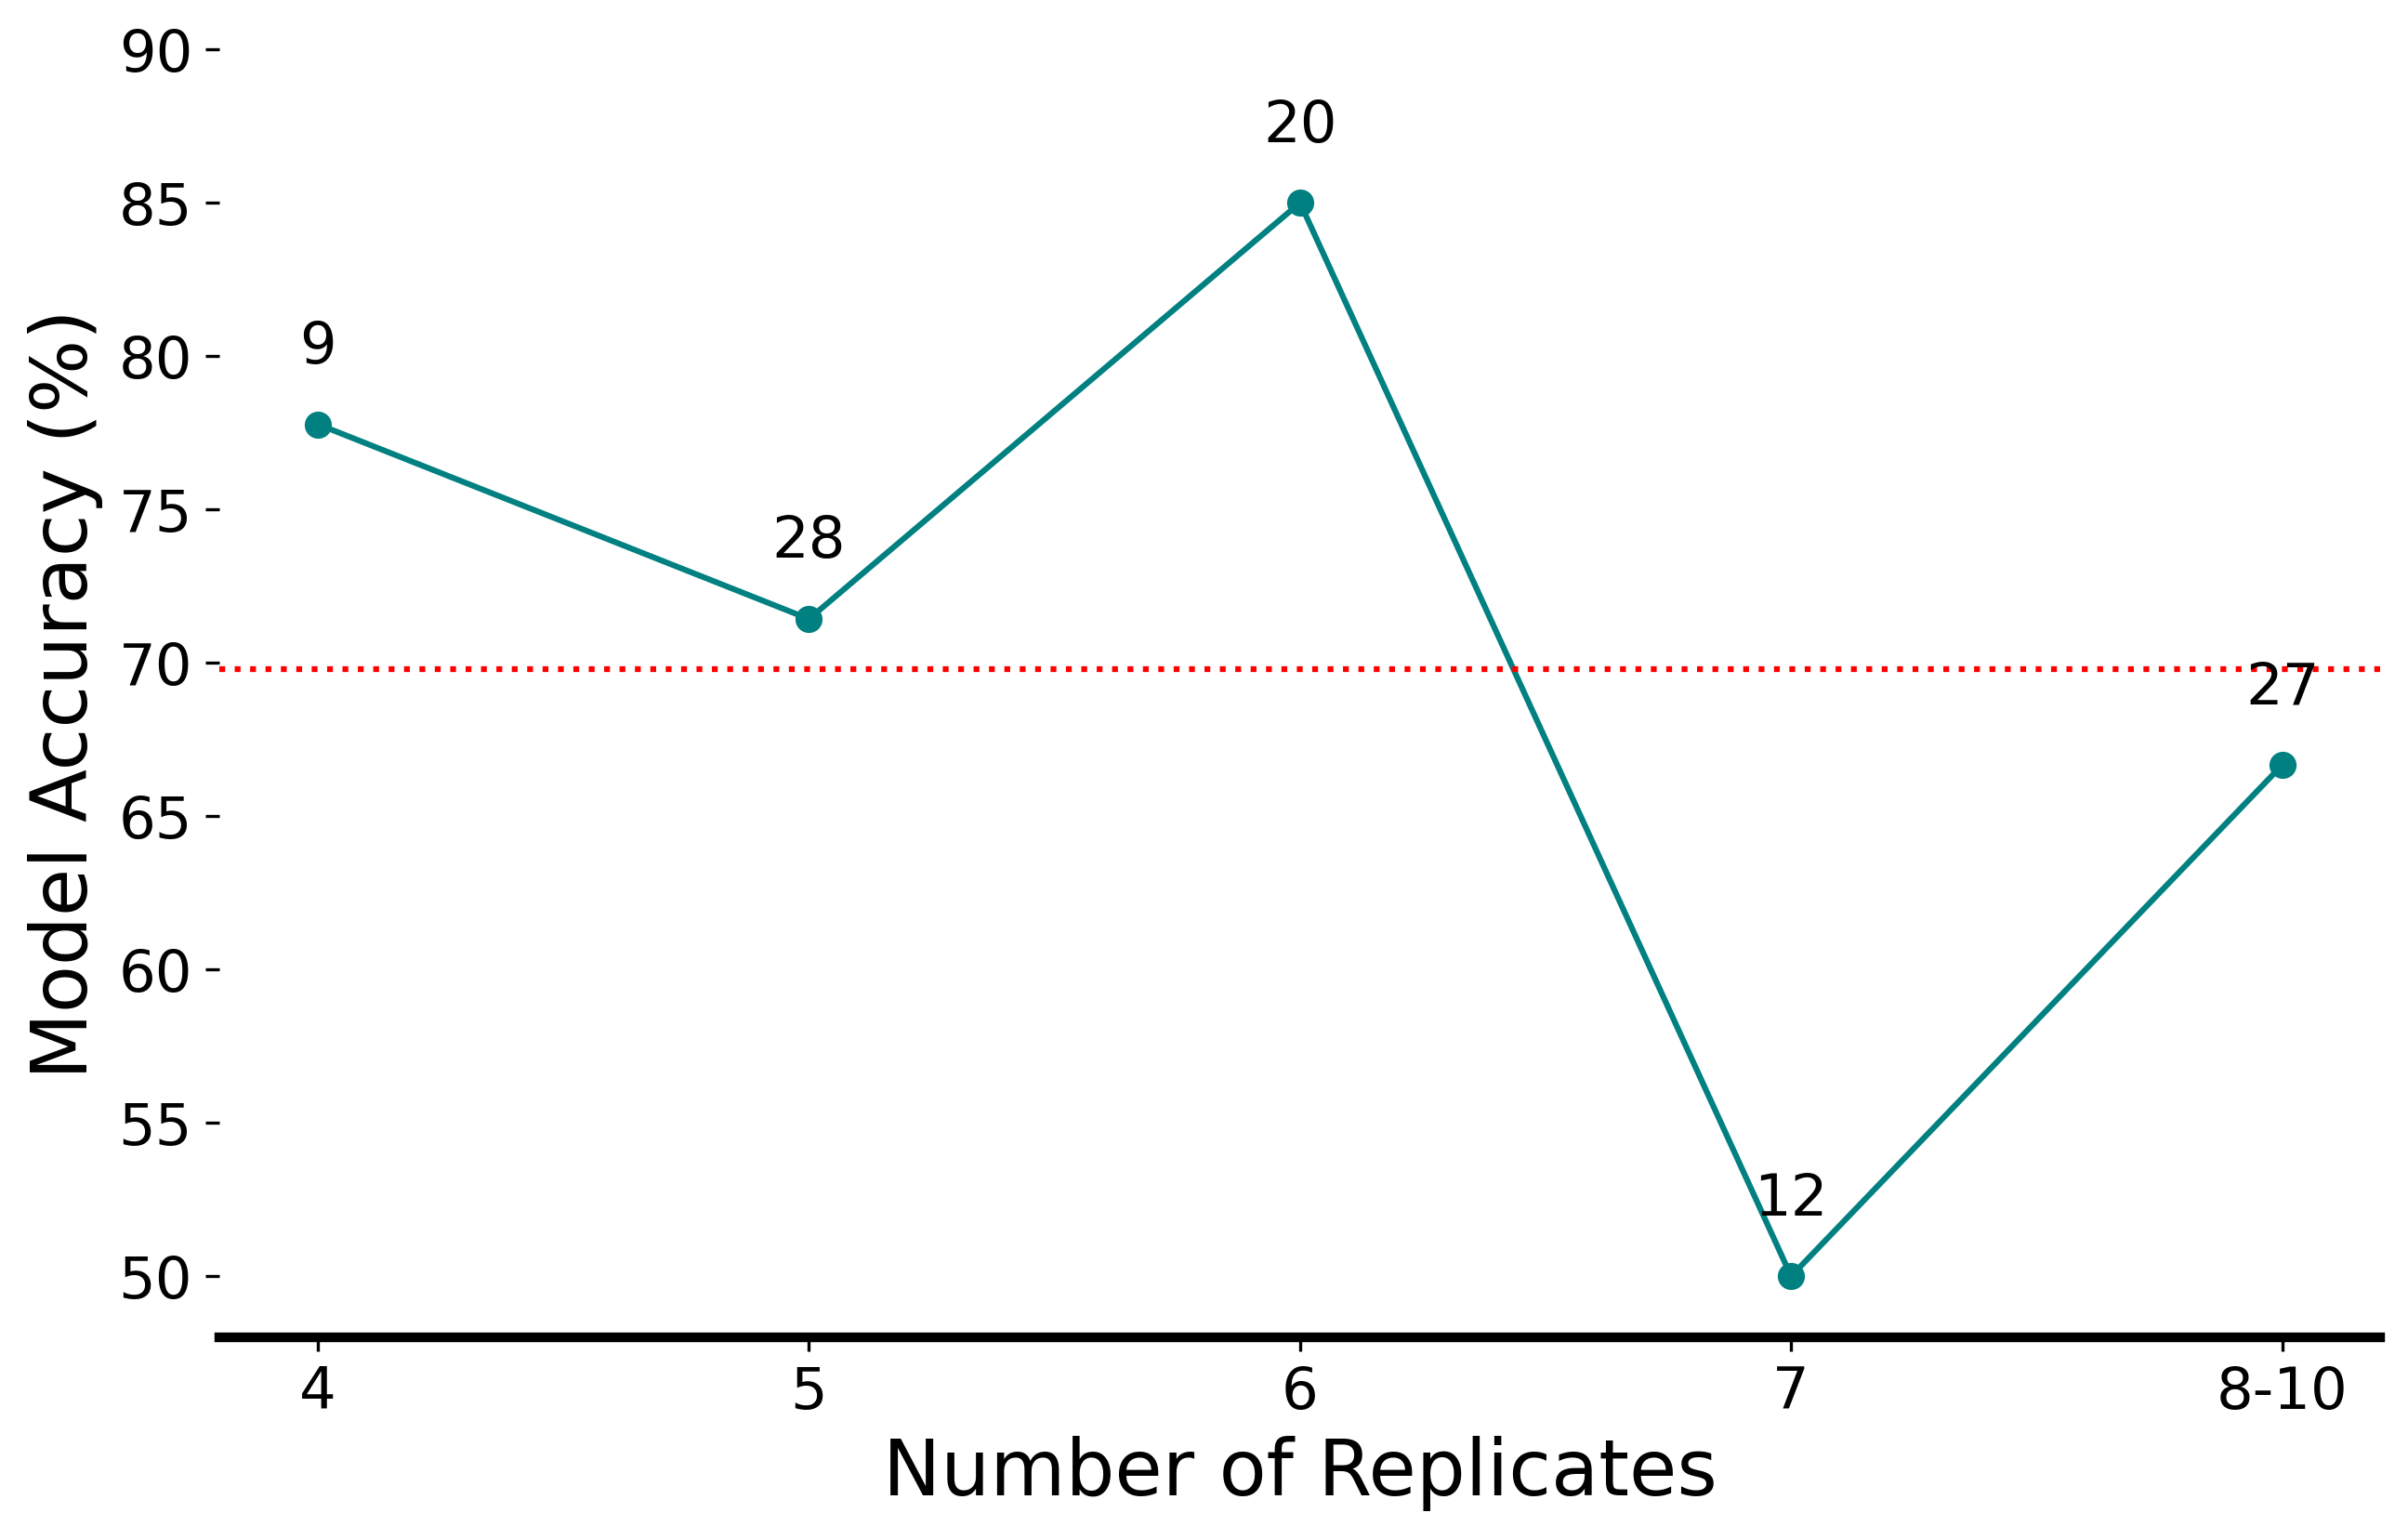

In [198]:
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(fus_rep_df['replicates'], fus_rep_df['accuracy'] * 100, marker='o', linestyle='-', label='Accuracy', color='teal')
for i, txt in enumerate(fus_rep_df['n_data']):
    plt.annotate(txt, (fus_rep_df['replicates'][i], fus_rep_df['accuracy'][i] * 100 + 2), ha='center')
plt.axhline(y=69.79, color='red', linestyle='dotted', label='CVF Accuracy')

plt.xlabel('Number of Replicates')
plt.ylabel('Model Accuracy (%)')
plt.ylim(48, 90)
# Save figure:
plt.savefig('output/Other_Viz/Replicate_Plot.png', bbox_inches='tight')
plt.show()

In [51]:
fus_rep_df.n_data.sum()

96

### Clinical Phase:

In [203]:
# Add clinical phase info to the data: 
fuse_well['clinical_phase'] = fuse_well.apply(match_id, ki_df=ki_meta, col_id='clinical_phase', axis=1)
clinical_fusion = col_agg(fuse_well, 'clinical_phase')
clinical_fusion = clinical_fusion.reset_index(drop=True)
clinical_fusion

,clinical_phase,accuracy,n_data
0,Preclinical,0.613636,44
1,Phase 1,0.750000,20
2,Phase 2,0.809524,21
3,Phase 3,0.800000,5
4,Launched,0.833333,6


In [133]:
clinical_fusion.n_data.sum()

96

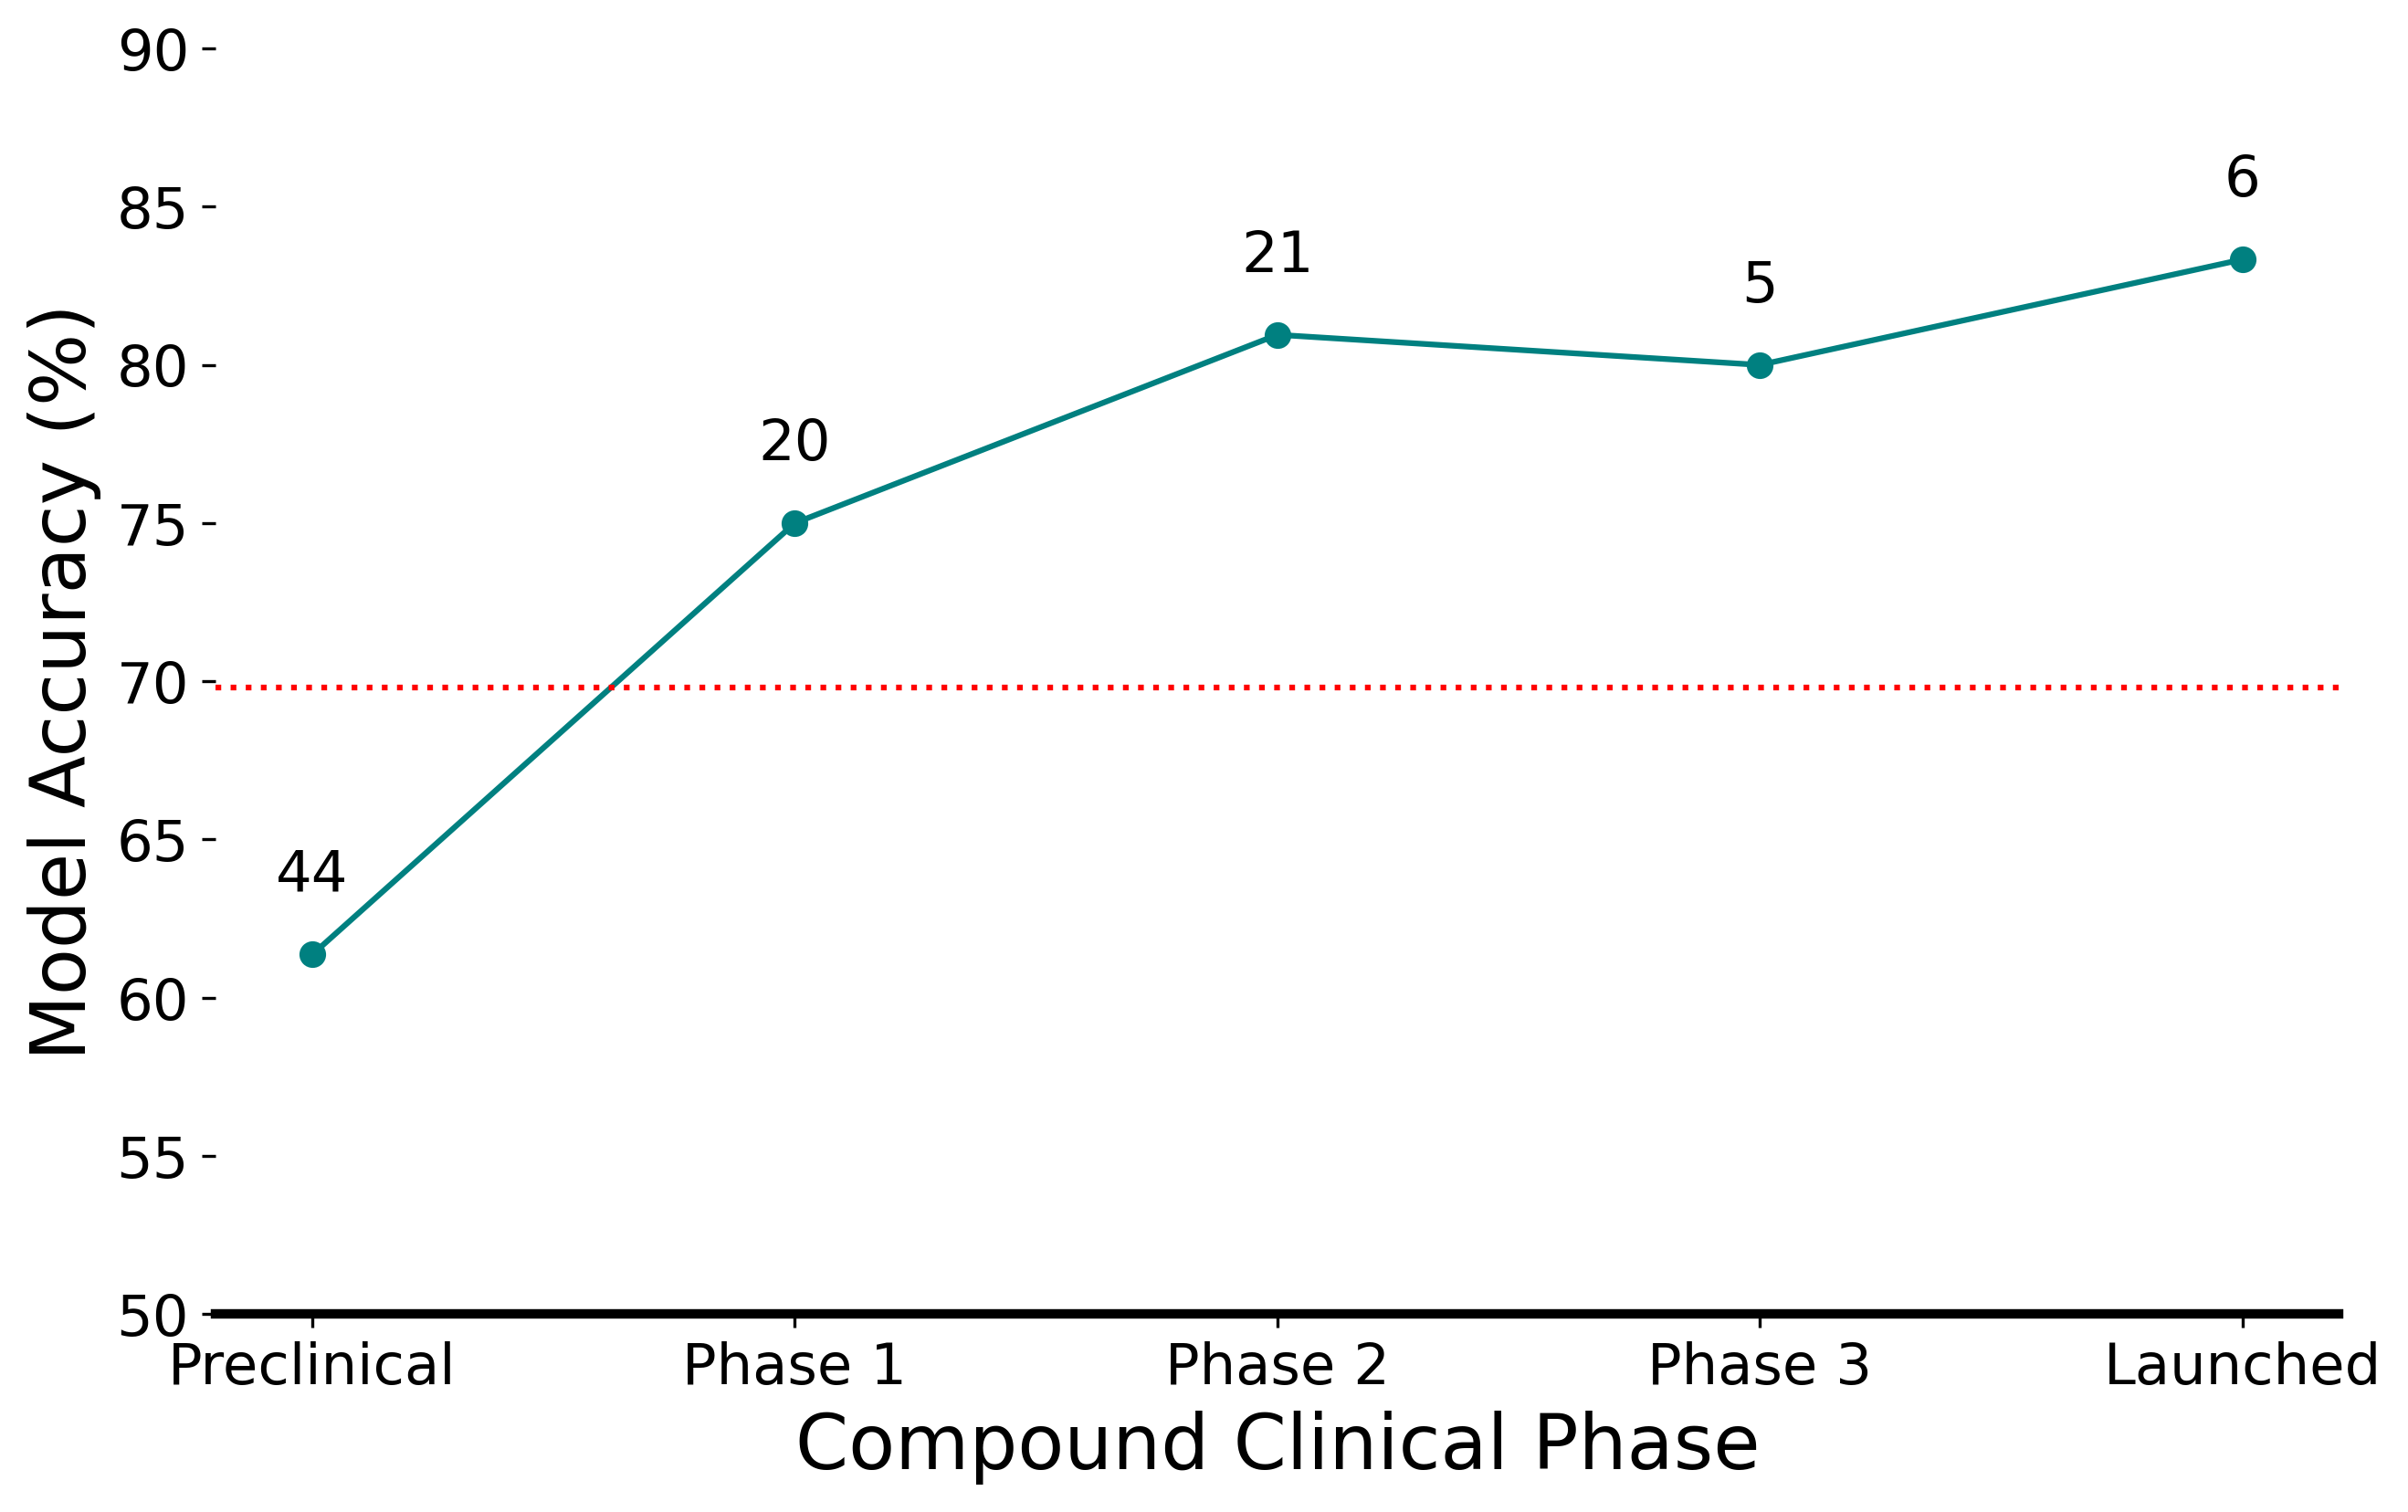

In [204]:
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(clinical_fusion['clinical_phase'], clinical_fusion['accuracy'] * 100, 
         marker='o', linestyle='-', label='Accuracy', color='teal')
for i, txt in enumerate(clinical_fusion['n_data']):
    plt.annotate(txt, (clinical_fusion['clinical_phase'][i], clinical_fusion['accuracy'][i] * 100 + 2), ha='center')
plt.axhline(y=69.79, color='red', linestyle='dotted', label='CVF Accuracy')

plt.xlabel('Compound Clinical Phase')
plt.ylabel('Model Accuracy (%)')
plt.ylim(50, 90)
# Save figure:
plt.savefig('output/Other_Viz/Clin_phase_Plot.png', bbox_inches='tight')
plt.show()

### Fields of View:

In [135]:
fov_dict = {'source_2': 6,'source_10': 6,'source_3': 9,'source_4': 9,'source_5': 9,'source_6': 9,
    'source_7': 9,'source_8': 9,'source_11': 9,'source_15': 9,'source_1': 4,'source_9': 4}

In [136]:
# Split 'well_ids' to extract the source
fuse_well['source'] = fuse_well['well_ids'].str.split('~').str[0]

# Map 'source' to the 'fov_dict' and create the 'fov' column
fuse_well['fov'] = fuse_well['source'].map(fov_dict)

In [146]:
fov_fusion = col_agg(fuse_well, 'fov')
fov_fusion

,fov,accuracy,n_data
2,4,0.500000,14
0,6,0.619718,71
1,9,0.705263,95


## Swin:

In [114]:
swin_well['cpnd_ids'] = swin_well.apply(match_id, ki_df=ki_ibp, col_id='Metadata_InChIKey', axis=1)
swin_rep_df = replicate_agg(swin_well)
swin_rep_df

,replicates,accuracy,n_data
2,10,0.470588,17
5,9,0.800000,5
6,8,1.000000,5
3,7,0.833333,12
1,6,0.650000,20
0,5,0.607143,28
4,4,0.666667,9


In [53]:
swin_rep_df.n_data.sum()

96

## IBP:

In [86]:
len(ibp_well.cpnd_ids.unique())

93

In [81]:
ibp_rep_df = replicate_agg(ibp_well, well_level=False)
ibp_rep_df

,replicates,accuracy,n_data
2,10,0.384615,13
6,9,0.600000,5
5,8,0.800000,5
3,7,0.833333,12
1,6,0.666667,15
0,5,0.678571,28
4,4,0.750000,8
7,3,0.666667,3
9,2,0.500000,2
8,1,0.500000,2


In [87]:
ibp_rep_df.n_data.sum()

93

# Comparing Model Performance:

## IBP Data Performance Comparison:

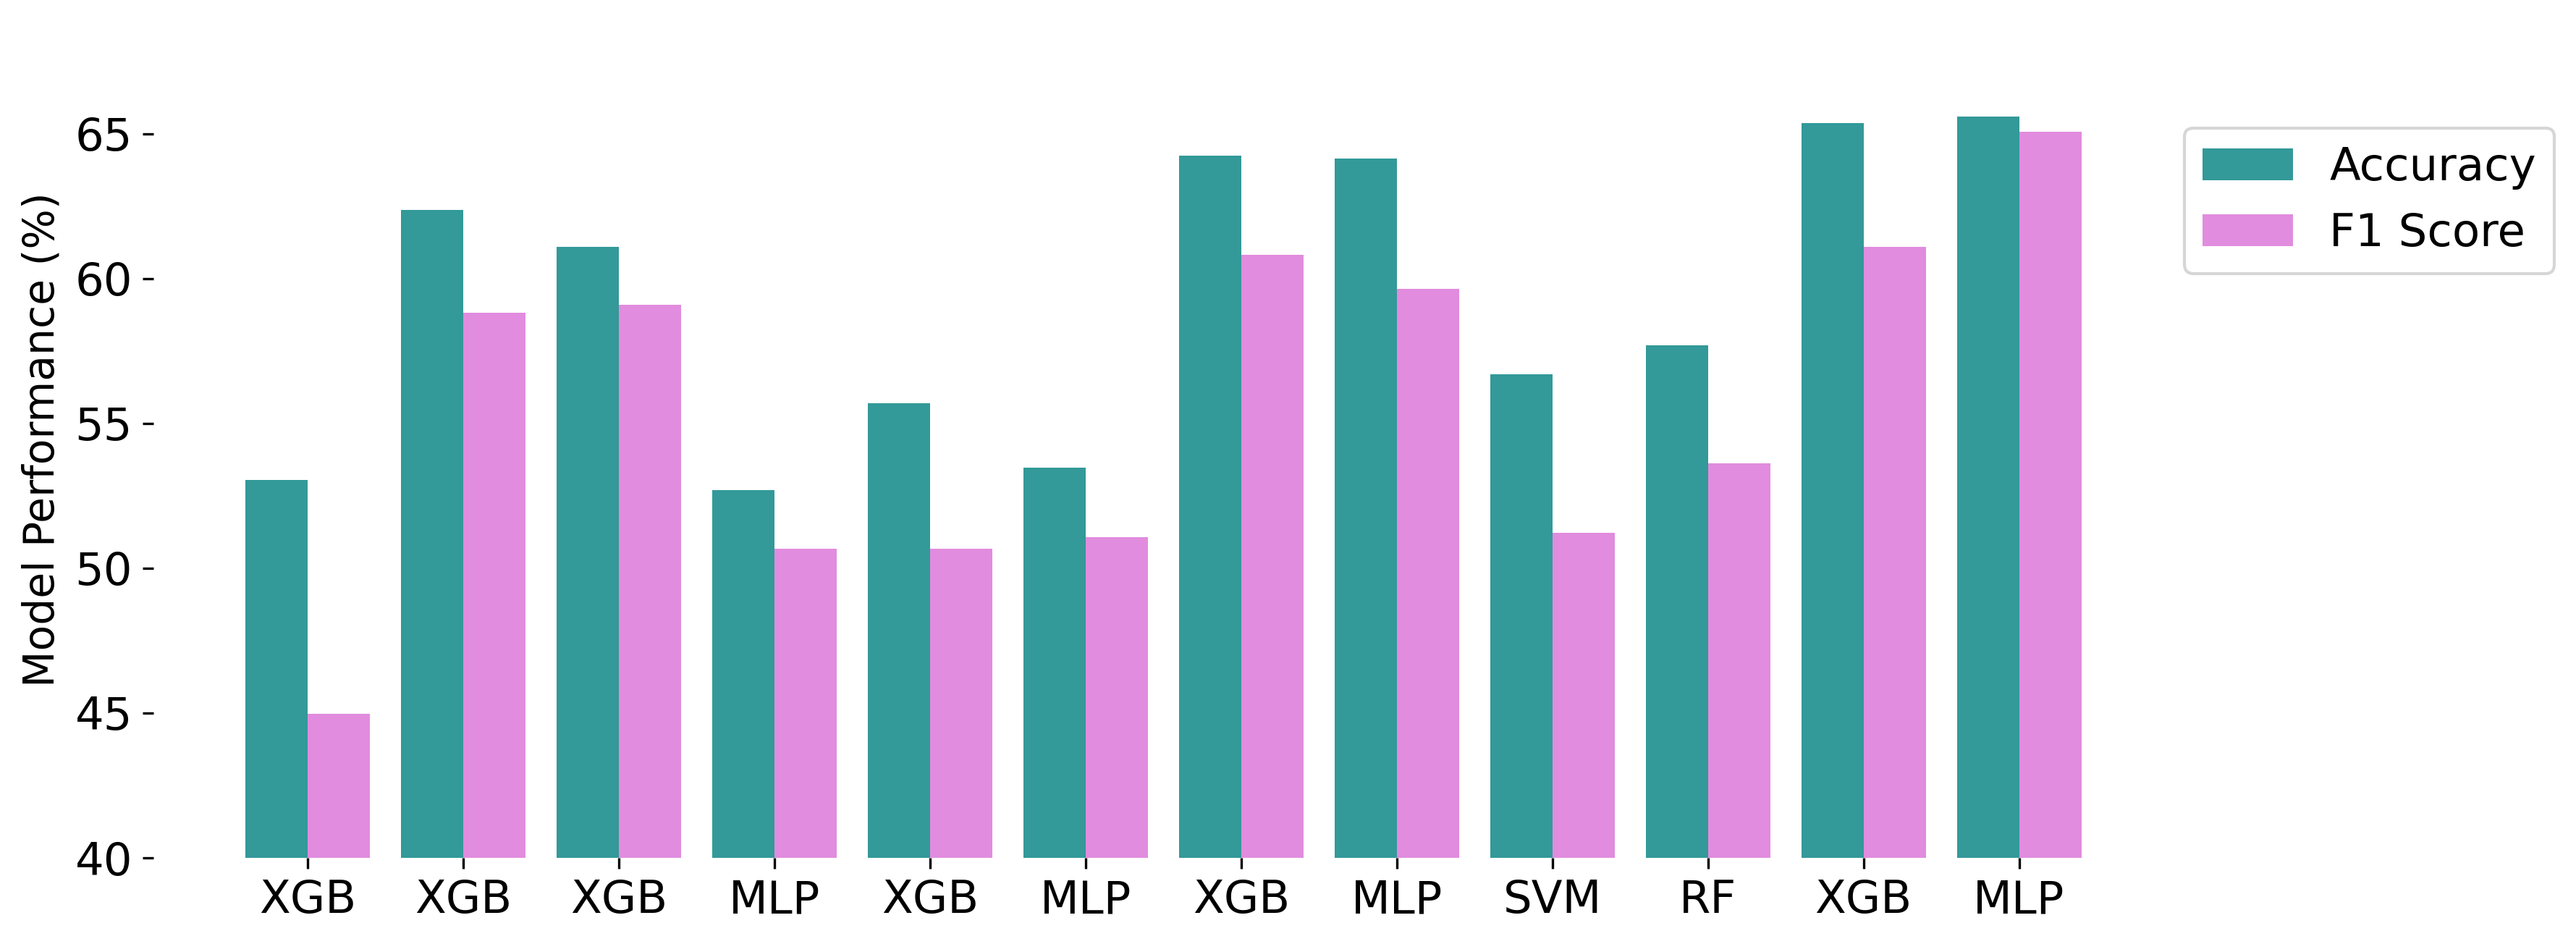

In [66]:
# Data
Acc_scores = [53.05, 62.37, 61.09, 52.69, 55.70, 53.48, 64.25, 64.13, 56.7, 57.70, 65.36, 65.59]
F1_scores = [44.97, 58.82, 59.08, 50.68, 50.67, 51.07, 60.81, 59.65, 51.21, 53.62, 61.09, 65.07]
models = ['XGB', 'XGB', 'XGB', 'MLP', 'XGB', 'MLP', 'XGB', 'MLP', 'SVM', 'RF', 'XGB', 'MLP']

mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

# Set the width of the bars
bar_width = 0.4

# Create an array for the x-axis positions
x = np.arange(len(models))

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

# Plot accuracy bars
acc_bars = ax.bar(x - bar_width/2, Acc_scores, bar_width, label='Accuracy', color='teal', alpha=0.8)

# Plot F1 score bars
f1_bars = ax.bar(x + bar_width/2, F1_scores, bar_width, label='F1 Score', color='orchid', alpha=0.8)

# Set the labels and legends:
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Model Performance (%)', fontsize=14)
ax.set_ylim(40, None)
ax.legend(bbox_to_anchor=(1.2,0.9))

# Save figure:
plt.savefig('output/Other_Viz/IBP_Results.png', bbox_inches='tight')

# Show the plot
plt.show()

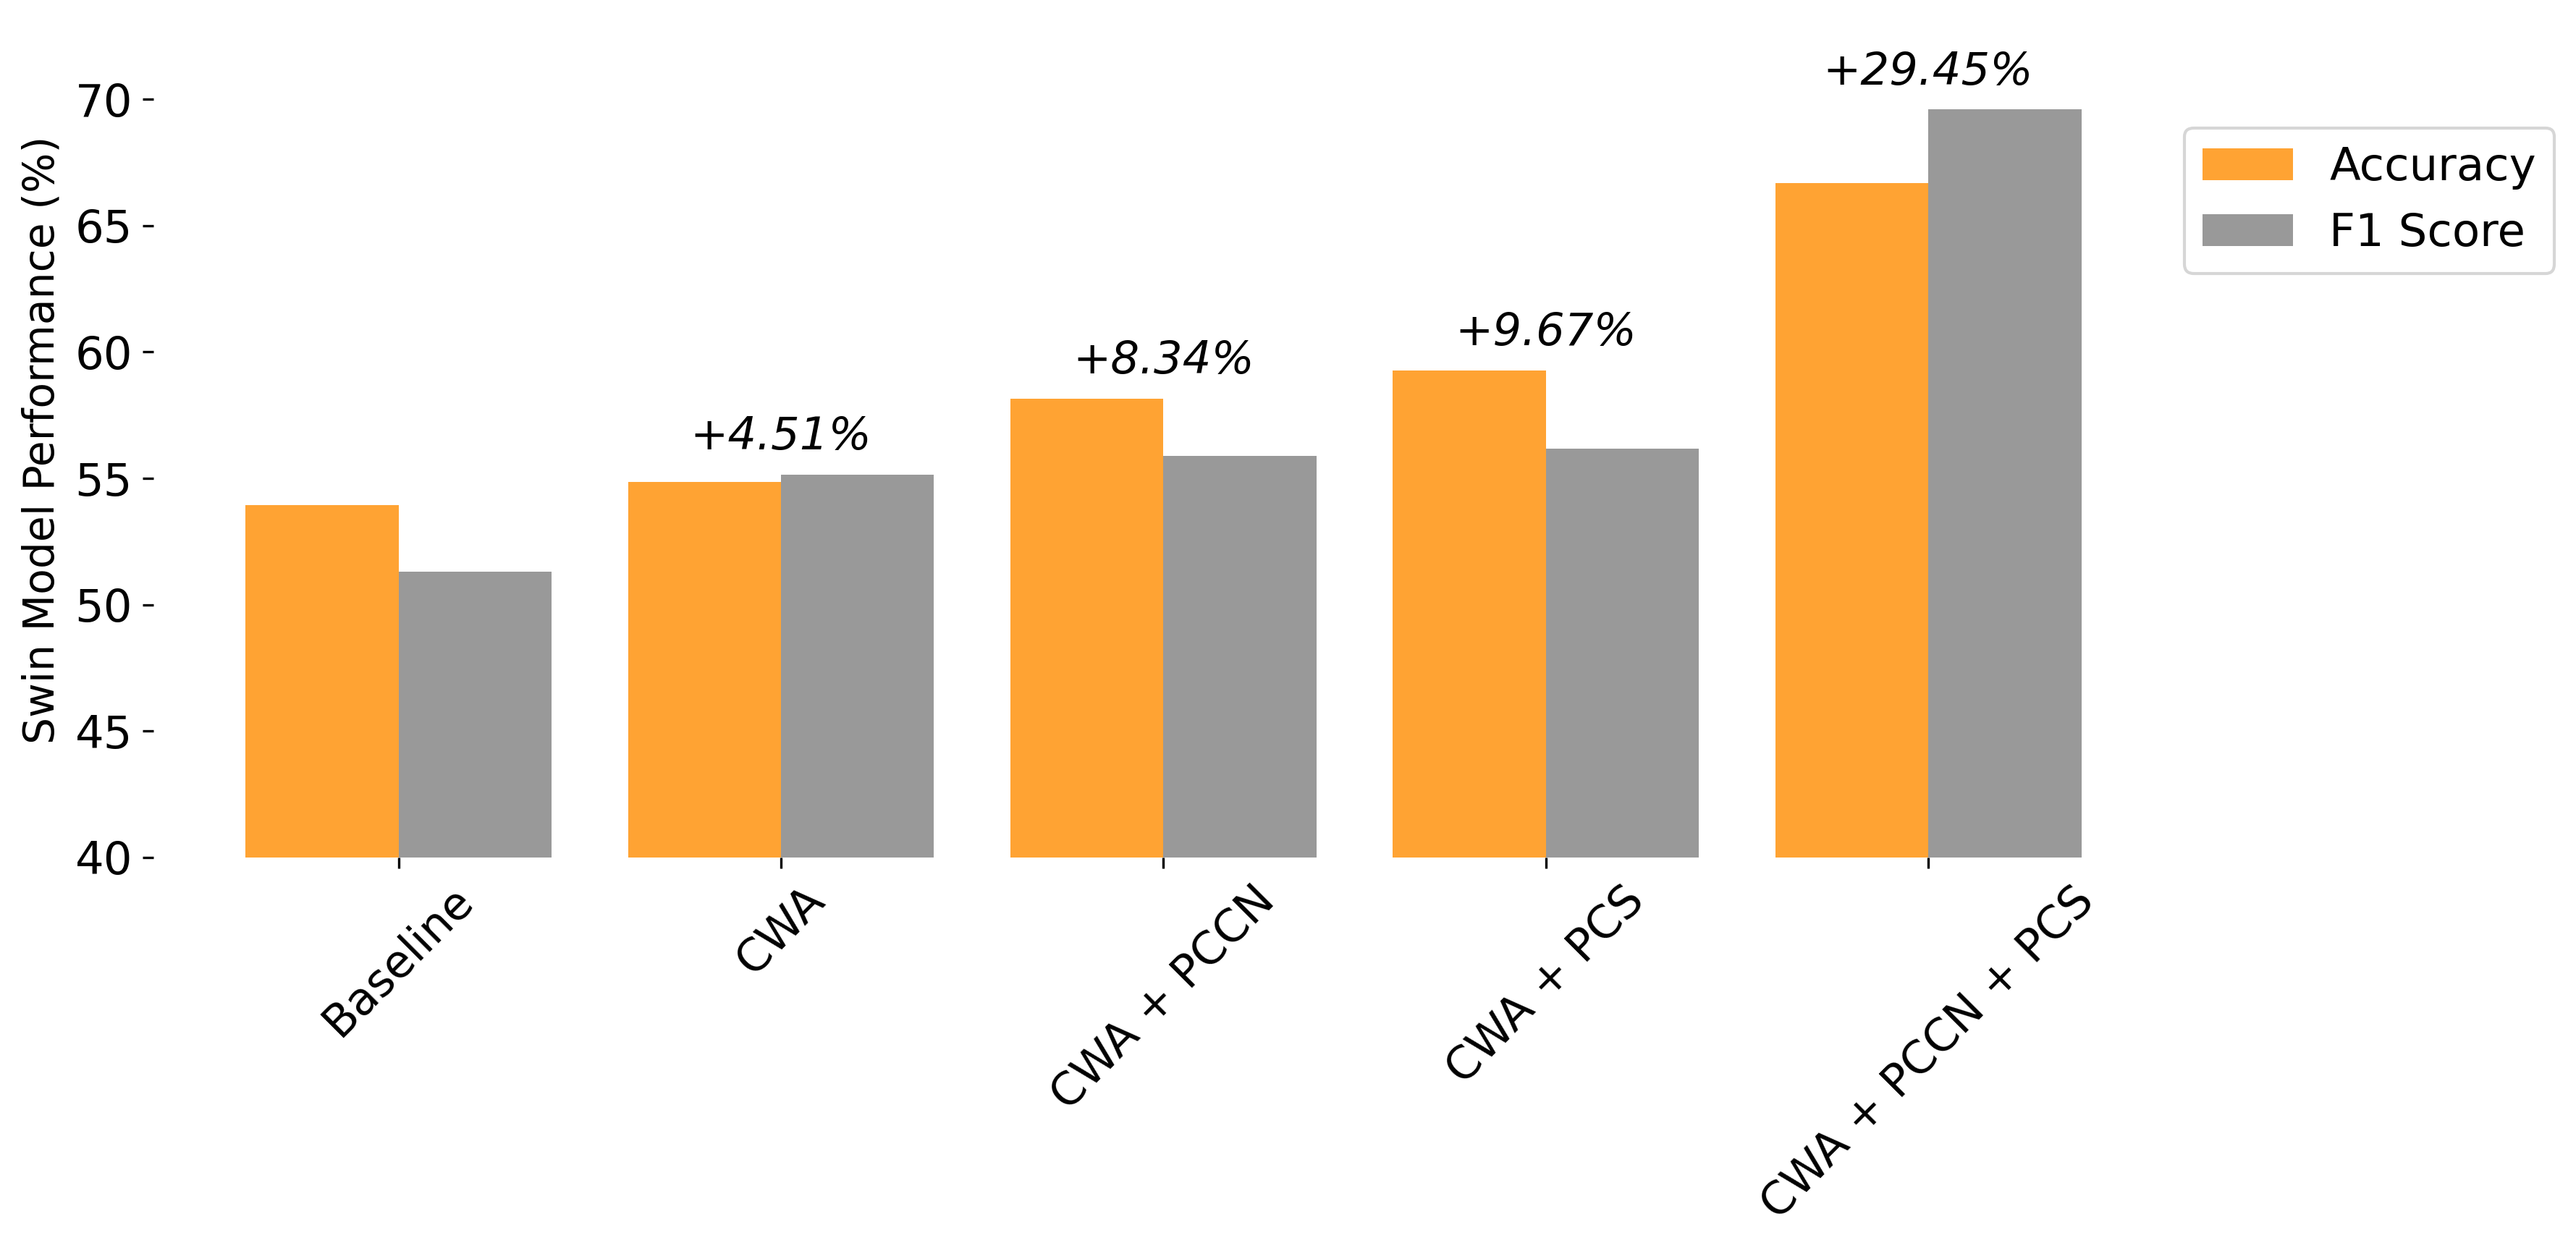

In [73]:
# Data
Acc_scores = [53.95, 54.86, 58.16, 59.26, 66.67]
F1_scores = [51.31, 55.15, 55.88, 56.18, 69.59]
models = ['Baseline', 'CWA', 'CWA + PCCN', 'CWA + PCS', 'CWA + PCCN + PCS']

mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

# Set the width of the bars
bar_width = 0.4

# Create an array for the x-axis positions
x = np.arange(len(models))

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

# Plot accuracy bars
acc_bars = ax.bar(x - bar_width/2, Acc_scores, bar_width, label='Accuracy', color='darkorange', alpha=0.8)

# Plot F1 score bars
f1_bars = ax.bar(x + bar_width/2, F1_scores, bar_width, label='F1 Score', color='grey', alpha=0.8)

# Calculate and add text labels for improvements
baseline_acc = Acc_scores[0]
baseline_f1 = F1_scores[0]
for i in range(1, len(models)):
    improvement = ((Acc_scores[i] + F1_scores[i]) / (baseline_acc + baseline_f1))-1
    improvement_text = f'+{improvement:.2%}'
    ax.text(x[i], max(Acc_scores[i], F1_scores[i]) + 1, improvement_text, ha='center', style='italic')

# Set the labels and legends:
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Swin Model Performance (%)', fontsize=14)
ax.set_ylim(40, None)
ax.legend(bbox_to_anchor=(1.2,0.9))
plt.xticks(rotation=45)

# Save figure:
plt.savefig('output/Other_Viz/Image_Results.png', bbox_inches='tight')

# Show the plot
plt.show()

In [20]:
resp = (Acc_scores[1] - baseline_acc) / 100
resp

0.009099999999999966

In [21]:
f'+{resp:.2%}'

'+0.91%'

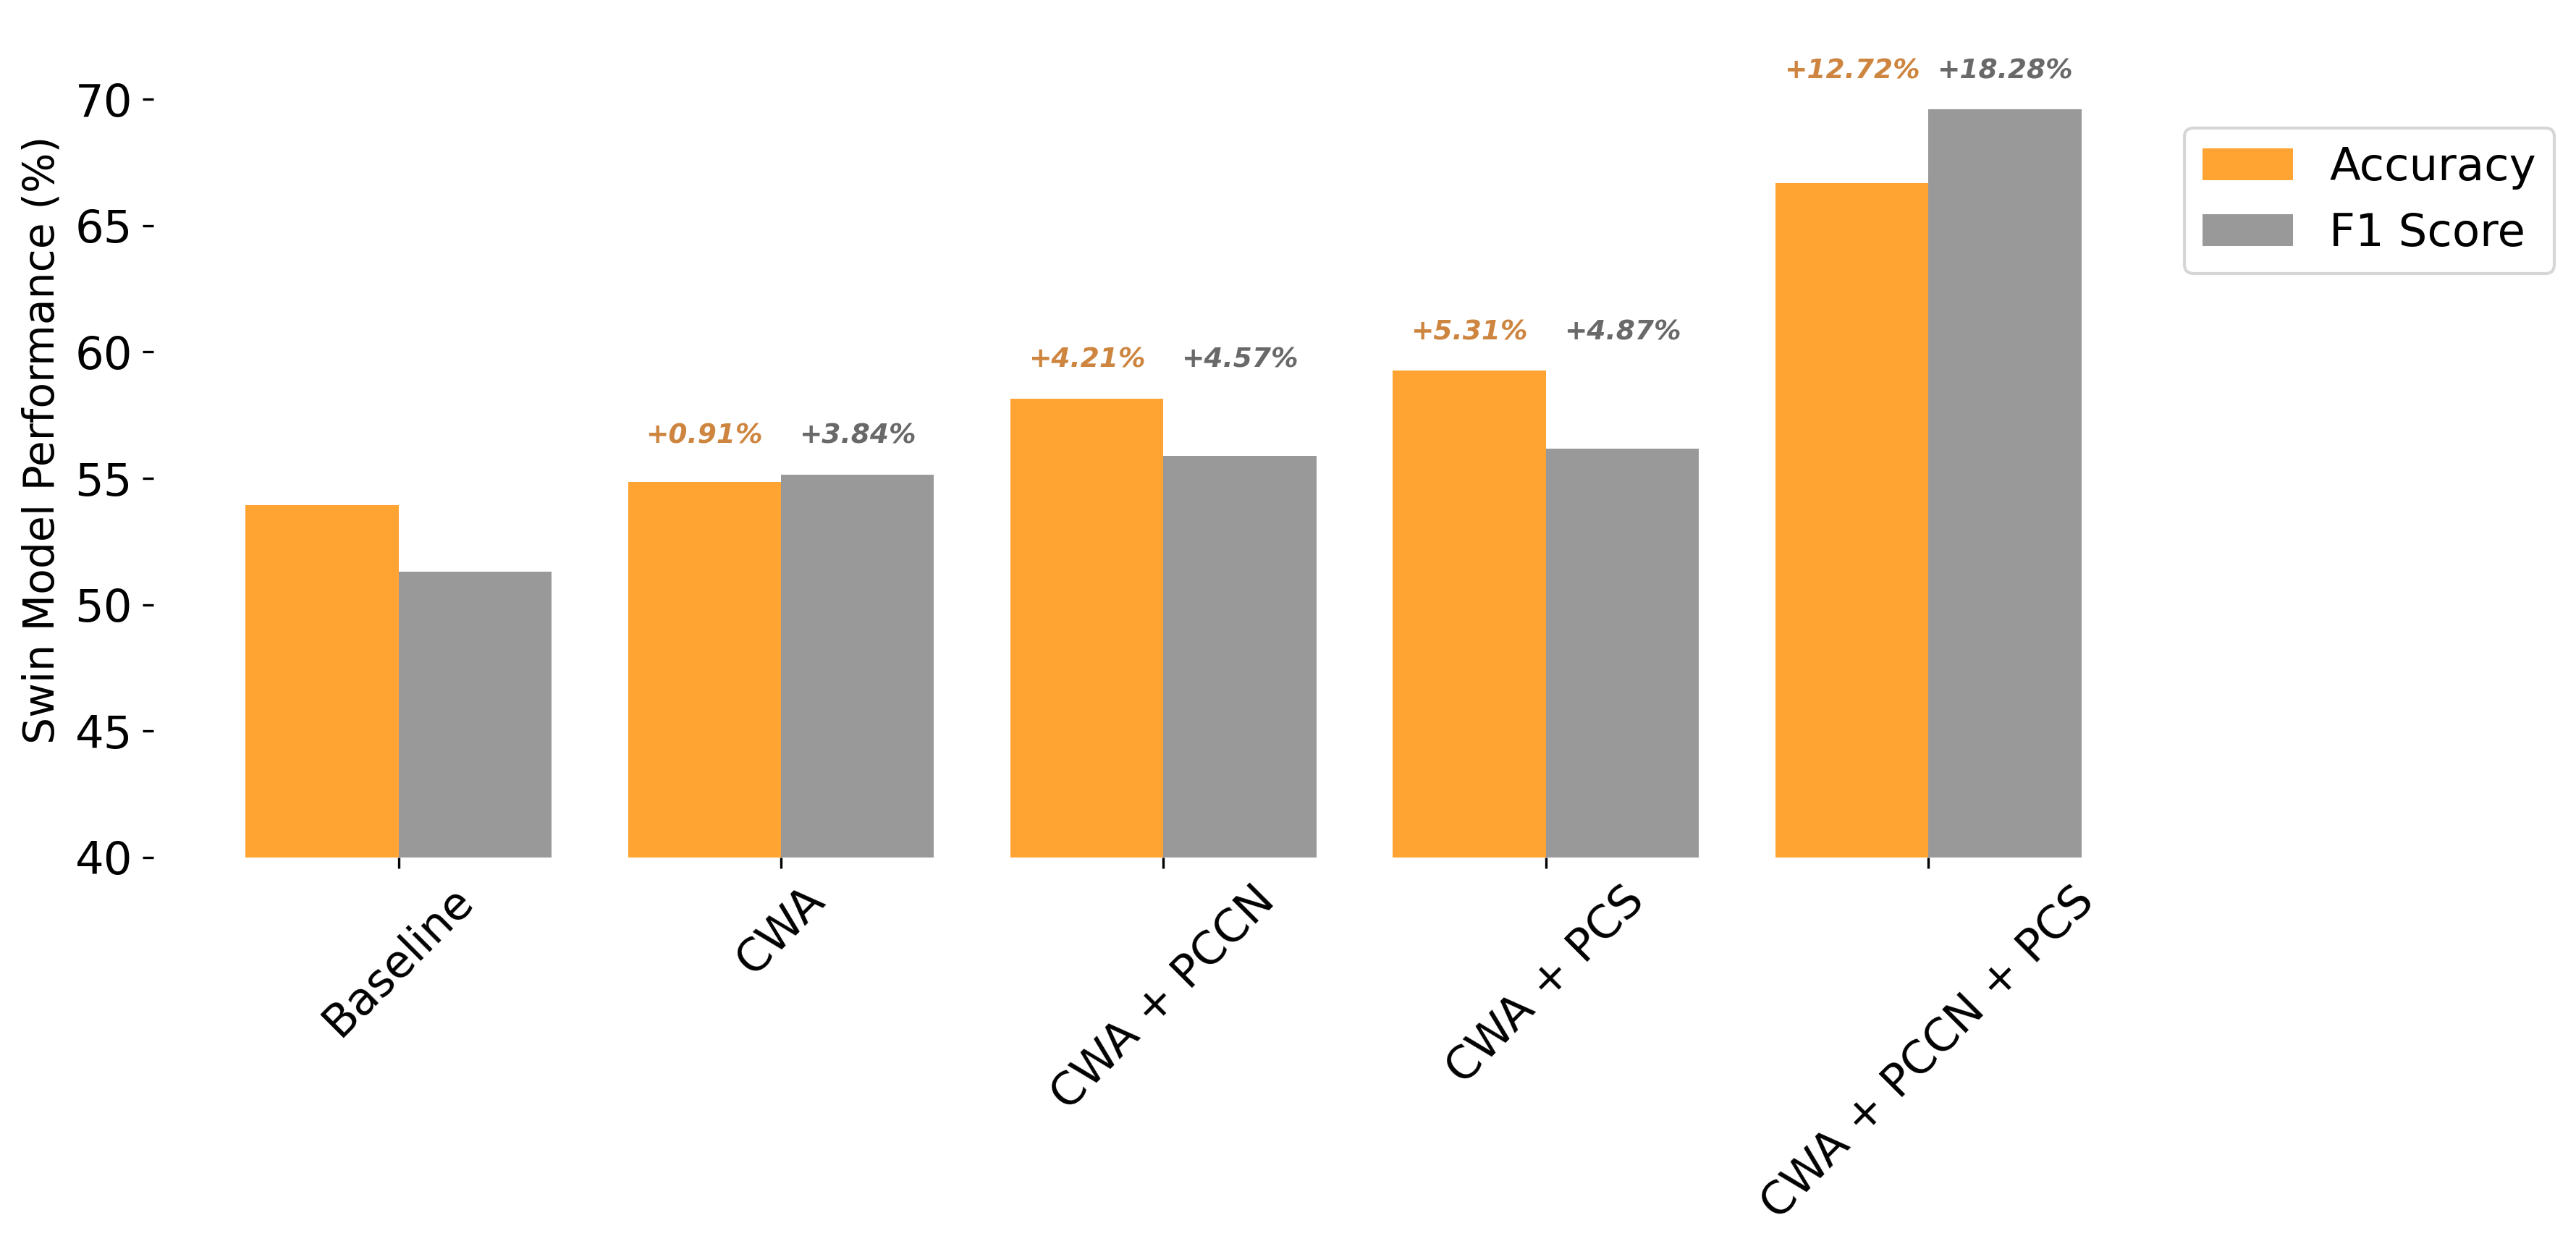

In [22]:
# Data
Acc_scores = [53.95, 54.86, 58.16, 59.26, 66.67]
F1_scores = [51.31, 55.15, 55.88, 56.18, 69.59]
models = ['Baseline', 'CWA', 'CWA + PCCN', 'CWA + PCS', 'CWA + PCCN + PCS']

mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

# Set the width of the bars
bar_width = 0.4

# Create an array for the x-axis positions
x = np.arange(len(models))

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

# Plot accuracy bars
acc_bars = ax.bar(x - bar_width/2, Acc_scores, bar_width, label='Accuracy', color='darkorange', alpha=0.8)

# Plot F1 score bars
f1_bars = ax.bar(x + bar_width/2, F1_scores, bar_width, label='F1 Score', color='grey', alpha=0.8)

# Add text labels for accuracy improvements
baseline_acc = Acc_scores[0]
for i in range(1, len(models)):
    improvement = (Acc_scores[i] - baseline_acc) / 100
    improvement_text = f'+{improvement:.2%}' 
    ax.text(x[i] - bar_width/2, max(Acc_scores[i], F1_scores[i]) + 1, improvement_text, ha='center', 
            va='bottom', color='peru', style='italic', fontsize=9, fontweight='bold')

# Add text labels for F1 score improvements
baseline_f1 = F1_scores[0]
for i in range(1, len(models)):
    improvement = (F1_scores[i] - baseline_f1) / 100
    improvement_text = f'+{improvement:.2%}'
    ax.text(x[i] + bar_width/2, max(Acc_scores[i], F1_scores[i]) + 1, improvement_text, ha='center', 
            va='bottom', color='dimgrey', style='italic', fontsize=9, fontweight='bold')

# Set the labels and legends:
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Swin Model Performance (%)', fontsize=14)
ax.set_ylim(40, None)
ax.legend(bbox_to_anchor=(1.2,0.9))
plt.xticks(rotation=45)

# Save figure:
plt.savefig('output/Other_Viz/Image_Results.png', bbox_inches='tight')

# Show the plot
plt.show()
